In [4]:
#!/usr/bin/env python3

import sys
import os
import numpy as np
from ase.io import read
# Add the directory containing tabulate.py to the Python path
sys.path.append(os.path.expanduser('~/bin/tabulate'))
from tabulate import tabulate


## Conversion constant

In [3]:
###########################################
###       All conversion rates          ###
###########################################

# Some constants 
c_cm_s    = 2.998e+10       # cm/s
h_bar     = 1.054571817e-34 # J*s

# Conversions from atomic unit
autoev   = 27.211383858491185
autoj    = 4.35974394e-18 
autocmm1 = 219474.63133081
autofs   = 0.02418884326505
autos    = 2.418884326505e-17
autoan   = 0.52917720859
autocm   = 0.52917720859e-8
autoamu  = 0.0005485799092659504
autoanf  = 21.876912541518593
autoamuA = autoamu * autoan**2 # Convert from atomic units to amu*Å^2

# Conversions to atomic unit
evtoau   = 0.03674932540
jtoau    = 2.293712689924629e+017
cmm1toau = 4.556335252760e-06
fstoau   = 41.341373336561364
stoau    = 4.134137333656137e+16
antoau   = 1.8897261328856432
cmtoau   = 188972613.28856432
amutoau  = 1822.888485540950
anftoau  = 0.045710289242239875

# Others conversions
ev_to_J  = 1.60218e-19
degtorad = 180 / np.pi
Antom    = 1e-10
amutoKg  = 1.66054e-27
Afstoms  = 1e5
mstoafs  = 1e-5


## Fonctions for the analysis

In [5]:

##########################################
###           All methods use          ###
##########################################

def get_diat_massCenter(A_pos, B_pos):
    massCenter_coord = []
    for i in range(3):
        massCenter_coord.append((A_mass * A_pos[i] + B_mass * B_pos[i])/(A_mass + B_mass))
    return massCenter_coord

def get_distance(P1, P2):
    return np.sqrt((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2 + (P1[2] - P2[2])**2)

def get_L3_z(coordinates):   
    n = 0
    z = 0
    for atom in coordinates[2:]:
        if atom[2] > 5 * antoau:
            z += atom[2]
            n += 1
    return z / n if n > 0 else 0

def cartesian_to_spherical(coord):
    r     = np.sqrt(sum([c**2 for c in coord]))
    theta = np.degrees(np.arccos(coord[2] / r)) if r != 0 else 0
    phi   = np.degrees(np.arctan2(coord[1], coord[0]))
    if phi < 0 and coord[1] < 0:
        phi += 360  # Adjust phi for the third and fourth quadrants
    return [r, theta, phi ]

def get_morsePotential(r, De, a, re ):
    return De * (1 - np.exp(-a*(r-re)))**2

def get_Params(coord, velocity):
    '''
    Get the most important distances and angles for diatomic molecule
    '''
    
    # Convert to atomic unit the input data
    coord          *= antoau
    velocity       *= anftoau
    
    #Set positions and velocities easier to use
    q_A                   = coord[0]
    q_B                   = coord[1]
    v_A                   = velocity[0]
    v_B                   = velocity[1]
    
    # Get intermolecular vector A-B
    q_AB                 = q_B - q_A                    # vector
    q_AB_norm            = np.linalg.norm(q_AB)         # au (distance)
    q_AB_direction       = q_AB / q_AB_norm if q_AB_norm != 0 else np.zeros(3)   # unitary vector
    
    # A and B velocities in the interatomic direction
    A_inter_vel           = np.dot(v_A, q_AB_direction)   # au (velocity)
    B_inter_vel           = np.dot(v_B, q_AB_direction)  # au (velocity)
    
    # Center of mass params
    mol_mass              = (A_mass + B_mass) * amutoau   # au (mass)
    mol_massCenter        = get_diat_massCenter(q_A, q_B)  # coordinates
    mol_mCenter_vel       = get_diat_massCenter(v_A, v_B)  # vector
    mol_mCenter_vel_norm  = np.linalg.norm(mol_mCenter_vel)                                                    # au (velocity)
    
    # Molecule High respect HOPG surface
    d_mol_L3              = mol_massCenter[2] - get_L3_z(coord) # au (distance)
    
    # Determine the output channel: scattered output_CH = 0, adsorbed output_CH = 1
    output_CH             = 0 if (d_mol_L3 * autoan) >= (detector_high - 0.1) else 1
    
    # Movement quantity and rotational vectors using methods from clasical phisycs
    pr_AB                = mu_AB_au * (v_B - v_A)                              # Compute p for diatom in [au]
    jr_mol                = np.cross(pr_AB, q_AB)  # Compute angular momentum [vector]
    pr_AB_inter          = np.dot(pr_AB, q_AB_direction)                       # Compute p in the interatomic direction [au]
    jr_mol_norm           = np.linalg.norm(jr_mol)                                # Angular momentum [au]
    
    # Quantum rotational number j
    jrotcont              =(-1.0 + np.sqrt(1.0 + 4.0 * jr_mol_norm**2)) * 0.5 if jr_mol_norm > 0 else 0
    jrotf                 = np.ceil(jrotcont)
    
    # Get molecule velocity orientation     
    mol_vel_theta         = np.degrees(np.arccos(mol_mCenter_vel[2]/np.linalg.norm(mol_mCenter_vel))) if mol_mCenter_vel_norm != 0 else 0                             # degree
    mol_vel_phi           = np.degrees(np.arccos(mol_mCenter_vel[0]/np.linalg.norm([mol_mCenter_vel[0], mol_mCenter_vel[1], 0]))) if mol_mCenter_vel_norm != 0 else 0  # degree 
    mol_vel_Sphe          = cartesian_to_spherical(mol_mCenter_vel)                                                                # spherical coordinates
    
    # Get AB theta and phi angles by analitic geometry equations
    AB_theta             = np.degrees(np.arccos(q_AB[2]/np.linalg.norm(q_AB))) if q_AB_norm != 0 else 0                   # degree
    AB_phi               = np.degrees(np.arccos(q_AB[0]/np.linalg.norm([q_AB[0], q_AB[1], 0]))) if q_AB_norm != 0 else 0 # degree
    
    # Get AB theta and phi angles by spheric coordinates equations
    B_pos                = q_B - mol_massCenter       # vector
    B_Spheric            = cartesian_to_spherical(B_pos)  # spherical coordinates
    
    # Molecule kinetic energy
    mol_Ekin              = 1/2 * mol_mass * np.square(mol_mCenter_vel_norm)                                  # au (energy)
    
    # Molecule potential energy
    mol_Epot              = get_morsePotential(q_AB_norm * autoan, De, a, re)    # eV
    
    # Molecule vibratonial energy
    mol_Evib              = (np.square(pr_AB_inter)/(2 * mu_AB_au))             # au (energy)
    
    # Molecule rotational energy
    mol_Erot              = 1/(2 * mu_AB_au) * np.square(jr_mol_norm / q_AB_norm) if q_AB_norm != 0 else 0 # au (energy)
    
    # Getting values back from au
    mol_massCenter = [x * autoan for x in mol_massCenter]
    mol_mCenter_vel = [x * autoanf for x in mol_mCenter_vel]
    
    # Create a dictionary with the calculated data
    data = {
        'output'          : output_CH                       ,
        'mol_massCenter'  : mol_massCenter                  ,
        'mol_mCenter_vel' : mol_mCenter_vel                 ,
        'mol_jrot'        : jrotf                           ,
        'AB_theta'       : round(B_Spheric[1]         , 2),
        'AB_phi'         : round(B_Spheric[2]         , 2),
        'AB_theta_a'     : round(AB_theta             , 2),
        'AB_phi_a'       : round(AB_phi               , 2),
        'd_AB'           : round(q_AB_norm   * autoan , 4),
        'd_mol_L3'        : round(d_mol_L3     * autoan , 4),
        'mol_vel_theta'   : round(mol_vel_Sphe[1]       , 2),
        'mol_vel_phi'     : round(mol_vel_Sphe[2]       , 2),
        'mol_vel_theta_a' : round(mol_vel_theta         , 2),
        'mol_vel_phi_a'   : round(mol_vel_phi           , 2),
        'mol_Ekin'        : round(mol_Ekin * autoev     , 4),
        'mol_Epot'        : round(mol_Epot              , 4),
        'mol_Evib'        : round(mol_Evib * autoev     , 4),
        'mol_Erot'        : round(mol_Erot * autoev     , 4)
    }
    return data




## Here starts the analysis

ValueError: could not convert string to float: ''

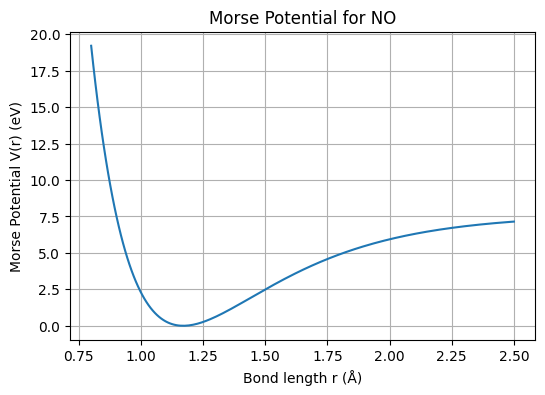

In [ ]:
# Prompt the user for the diatomic molecule
print()
atom_A = 'N' #input("Enter the first atom symbol of the diatomic (e.g., N): ")
atom_B = 'O' #input("Enter the second atom symbol of the diatomic (e.g., O): ")
atom_C = 'C' #input("Enter the surface atom symbol (e.g., C): ")
SPECORDER = [atom_A, atom_B, atom_C]  # Specify the order of atom types for LAMMPS
A_mass = 14.00674 #float(input(f"Enter the mass of {atom_A} in u: "))
B_mass = 15.999 #float(input(f"Enter the mass of {atom_B} in u: "))
C_mass = 12.0107 #float(input(f"Enter the mass of {atom_C} in u: "))
A_kg_mass = A_mass * amutoKg
B_kg_mass = B_mass * amutoKg
C_kg_mass = C_mass * amutoKg

# Morse potential constants for the diatomic
print()
De = 7.645438936565258 #float(input("Enter De for Morse potential (eV): "))
a = 2.565143344509797 #float(input("Enter a for Morse potential (1/Å): "))
re = 1.17028471793808 #float(input("Enter re for Morse potential (Å): "))

# Reduced mass
mu_AB_amu    = A_mass * B_mass / (A_mass + B_mass)
mu_AB_au     = mu_AB_amu * amutoau
mu_AB        = A_kg_mass * B_kg_mass / (A_kg_mass + B_kg_mass) # Kg

print()
Energy_input  = "01" #input("Enter the energy value in eV separated by commas (DON'T use points, 0.1 --> 01 for instance): ")
E             = [e.strip() for e in Energy_input.split(',')]

n_atoms       = 98 #int(input("Enter the total number of atoms (diatomic + surface): "))

# Types of configurations
cfg_names      = ["Start", "End"]

# Headers for the tables
Header_all    = ["Tray"         , f"{atom_A}{atom_B}cm_x"      , f"{atom_A}{atom_B}cm_y"     , f"{atom_A}{atom_B}_theta (°)", f"{atom_A}{atom_B}_phi (°)"  , "V_theta (°)",
                 "V_phi (°)"    , "End_time(fs)", "Output"       , "Vel_x(Å/fs)"  , "Vel_y(Å/fs)"  , "Vel_z(Å/fs)",
                 "Mol high(Å)"  , "Ekin(eV)"     , "Evib(eV)"    , "j rot"        ,"Scat_angle(°)" , "Et_f-Et_0(eV)", 'E_rot(eV)']
Header_state  = ["Tray"         , "time(fs)"     , f"d{atom_A}{atom_B}(Å)"     , "Mol high(Å)"  , "VcmZ_angle(°)", "Epot_f(eV)"   , "Ekin(eV)"     , "Evib(eV)"     , "j rot"]
Header_prob   = ["Energy"       , "n_tray"       , "Scattered"  , "Adsorbed"  , "Scat(%)" , "Ads(%)"]

print()
incidence   = "Normal" #input("Enter the diatomic molecule incidence (Normal/Oriented): ")

# Validate the incidence input
if incidence not in ["Normal", "Oriented"]:
    print("Invalid incidence. Please enter either 'Normal' or 'Oriented'.")
    exit(1)

print()
temperature = float(input("Enter the temperature (K): "))
if temperature < 0:
    print("Invalid temperature. Please enter a non-negative value.")
    exit(1)

print()
detector_high = 8.0 #float(input("Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation): "))

print()
file_format = "LAMMPS" #input("Enter the file format (XYZ or LAMMPS or VASP): ").upper()
if file_format not in ["XYZ", "LAMMPS", "VASP"]:
    print("Invalid format. Please enter either 'XYZ' or 'LAMMPS' or 'VASP'.")
    exit(1)

conditions = f"{int(temperature)}K_{detector_high}A" 

OUTPUT_PATH= f"{incidence}_{conditions}_Results/"
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Automatically detect energies and trajectories
# Assuming directories are named {incidence}_{int(temperature)}K_{energy}eV_dump_files for LAMMPS
base_dir_pattern = f"{incidence}_{int(temperature)}K_{{energy}}eV_dump_files" if file_format == "LAMMPS" else \
                   f"{incidence}_{int(temperature)}K_{{energy}}eV_XYZ_files" if file_format == "XYZ" else \
                   f"{incidence}_{int(temperature)}K_{{energy}}eV_VASP_files"

# Override E if needed, but use input E
# For each energy, find all traj files
results = {energy: {cfg: {"prop": [], "coord": [], "vel": []} for cfg in cfg_names} for energy in E}

frame_map = {"Start": 0, "End": -1}  # First and last frame

for energy in E:
    if file_format == "LAMMPS":
        dir_path = f"{incidence}_{int(temperature)}K_{energy}eV_dump_files"
        file_pattern = "nve_"
        ext = ".lammpstrj"
        format_ase = 'lammps-dump-text'
    elif file_format == "XYZ":
        dir_path = f"{incidence}_{int(temperature)}K_{energy}eV_XYZ_files"
        file_pattern = ""
        ext = ".xyz"
        format_ase = 'xyz'
    elif file_format == "VASP":
        dir_path = f"{incidence}_{int(temperature)}K_{energy}eV_VASP_files"
        file_pattern = "vasprun_"
        ext = ".xml"
        format_ase = 'vasp-xml'
    
    if not os.path.exists(dir_path):
        print(f"Directory {dir_path} not found for energy {energy}")
        continue
    
    # List files and extract traj numbers
    files = [f for f in os.listdir(dir_path) if f.startswith(file_pattern) and f.endswith(ext)]
    traj_nums = []
    for f in files:
        try:
            num_str = f[len(file_pattern):f.rfind(ext)]
            traj_nums.append(int(num_str))
        except ValueError:
            continue
    traj_nums.sort()
    
    if not traj_nums:
        print(f"No trajectories found in {dir_path}")
        continue
    
    print(f"Found trajectories {traj_nums[0]} to {traj_nums[-1]} for energy {energy}")
    
    for traj in traj_nums:
        file_path = os.path.join(dir_path, f"{file_pattern}{traj}{ext}")
        try:
            if file_format == "LAMMPS":
                atoms_list = read(file_path, index=':', format='lammps-dump-text',
                      specorder=SPECORDER, units='metal')#, columns=['id','type','x','y','z','vx','vy','vz','fx','fy','fz'], order=True)
            else:   
                atoms_list = read(file_path, format=format_ase, index=':')

        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
        
        n_cfg = len(atoms_list)
        if n_cfg < 2:
            print(f"Not enough frames in {file_path}")
            continue
        
        for cfg, frame_idx in frame_map.items():
            frame = frame_idx if frame_idx >= 0 else n_cfg + frame_idx
            if frame < 0 or frame >= n_cfg:
                print(f"Frame {frame} out of range for {cfg} in traj {traj}")
                continue
            atoms = atoms_list[frame]
            coord = atoms.get_positions()

            if file_format == "LAMMPS":
                arr = atoms.arrays

                if 'vx' in arr and 'vy' in arr and 'vz' in arr:
                    vel = np.column_stack([arr['vx'], arr['vy'], arr['vz']])  # Å/ps
                elif 'velocities' in arr:
                    vel = arr['velocities']  # Å/ps
                elif 'momenta' in arr:
                    m = atoms.get_masses()[:, None]
                    vel = arr['momenta'] / m  # Å/ps
                else:
                    vel = np.zeros_like(coord)
            
            else:
                vel = atoms.get_velocities() if atoms.has('velocities') else np.zeros_like(coord)

            # For properties, use tray=traj, time=frame * timestep (assume 1 fs)
            prop = np.array([traj, frame * 1.0, 0.0, atoms.get_potential_energy() if atoms.calc else 0.0, 0.0, 0.0, 0.0])  # Adjust as needed
            results[energy][cfg]["prop"].append(prop)
            results[energy][cfg]["coord"].append(coord)
            results[energy][cfg]["vel"].append(vel)

# Analysis
for energy in E:
    n_traj = len(results[energy]["Start"]["prop"])
    if n_traj == 0:
        continue
    
    #################################################
    ###     Get resume of all trayectories        ###
    #################################################
    
    table = []
    for j in range(n_traj):
        tray_prop_start = results[energy]["Start"]["prop"][j]
        params_0 = get_Params(results[energy]["Start"]["coord"][j], results[energy]["Start"]["vel"][j])
        params_f = get_Params(results[energy]["End"]["coord"][j], results[energy]["End"]["vel"][j])
        end_prop = results[energy]["End"]["prop"][j]
        table.append([tray_prop_start[0], 
                      round(params_0['mol_massCenter'][0], 4), 
                      round(params_0['mol_massCenter'][1], 4), 
                      params_0['AB_theta'], 
                      params_0['AB_phi'], 180 - params_0['mol_vel_theta_a'], 
                      params_0['mol_vel_phi_a'], 
                      end_prop[1], 
                      params_f['output'], 
                      round(params_f['mol_mCenter_vel'][0], 5),
                      round(params_f['mol_mCenter_vel'][1], 5), 
                      round(params_f['mol_mCenter_vel'][2], 5), 
                      params_f['d_mol_L3'], 
                      params_f['mol_Ekin'],
                      params_f['mol_Evib'] + params_f['mol_Epot'], 
                      params_f['mol_jrot'], 
                      params_f['mol_vel_theta_a'], 
                      end_prop[3] - tray_prop_start[3], 
                      params_f['mol_Erot']])
    
    with open(OUTPUT_PATH + str(energy) + "eV_all_Tray.dat", 'w') as f:
        f.write(tabulate(table, Header_all, tablefmt="plain", stralign="center", numalign="center"))
    
    ##########################################################
    ###     Get resume of states for all trayectories      ###
    ##########################################################
    
    for cfg in cfg_names[1:]:
        table = []
        for k in range(n_traj):
            tray_prop_start = results[energy]["Start"]["prop"][k]
            params = get_Params(results[energy][cfg]["coord"][k], results[energy][cfg]["vel"][k])
            prop_k = results[energy][cfg]["prop"][k]
            table.append([tray_prop_start[0], prop_k[1], params['d_AB'], params['d_mol_L3'], 
                          params['mol_vel_phi_a'], prop_k[5], params['mol_Ekin'], params['mol_Evib'] + params['mol_Epot'], params['mol_jrot']])
        with open(OUTPUT_PATH + str(energy) + "eV_" + cfg + "_Tray.dat", 'w') as f:
            f.write(tabulate(table, Header_state, tablefmt="plain", stralign="center", numalign="center"))

#####################################################
###     Get probabilities                           ###
#####################################################

table_prob = []
for energy in E:
    file_path = OUTPUT_PATH + str(energy) + "eV_all_Tray.dat"
    if not os.path.exists(file_path):
        continue
    data = np.loadtxt(file_path, skiprows=1)
    n_tray = len(data)
    out_ch_count = [0, 0]
    for row in data:
        out_ch_count[int(row[8])] += 1  # Adjusted for Output position
    table_prob.append([energy, n_tray, out_ch_count[0], out_ch_count[1], 
                       out_ch_count[0]/n_tray*100 if n_tray else 0, out_ch_count[1]/n_tray*100 if n_tray else 0])
with open(OUTPUT_PATH + "Prob.dat", 'w') as f:
    f.write(tabulate(table_prob, Header_prob, tablefmt="plain", stralign="center", numalign="center"))

print('Done !!!')